# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

In [1]:
%matplotlib inline

import warnings
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.linear_model import SGDClassifier, PassiveAggressiveClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from scipy.sparse import csr_matrix
from sklearn.svm import LinearSVC

from matplotlib import pyplot as plt

warnings.simplefilter("ignore")
PATH_TO_DATA = '../data'

In [3]:
df = pd.read_csv(os.path.join(PATH_TO_DATA, 'new_df_all.train'), index_col=0)
df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var218_cJvF,Var201_6dX3,Var201_smXZ,Var208_kIsH,Var208_sBgB,New_Var191,New_Var224,New_Var215,New_Var213,target
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,0,0,0,1,0,0,0,0,0,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,1,0,0,1,0,0,0,0,0,-1


In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

X = df.iloc[:, :-1].fillna(0).values
y = df.target.values

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

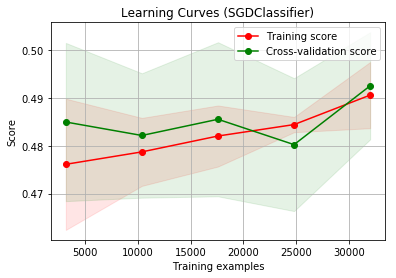

In [5]:
estimator = SGDClassifier(random_state=42)
train_sizes = np.linspace(.1, 1.0, 5)

train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=skf, n_jobs=-1, 
                                                        train_sizes=train_sizes, scoring='roc_auc')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title('Learning Curves (SGDClassifier)')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
_ = plt.legend(loc="best")

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [6]:
scores_mean = []
scores_std = []

for out_weight in np.linspace(.1, 0.9, 10):
    class_weight = {1:out_weight, -1:1 - out_weight}
    estimator = SGDClassifier(random_state=42, class_weight=class_weight)
    score = cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc')
    scores_mean.append(score.mean())
    scores_std.append(score.std())

In [7]:
scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)

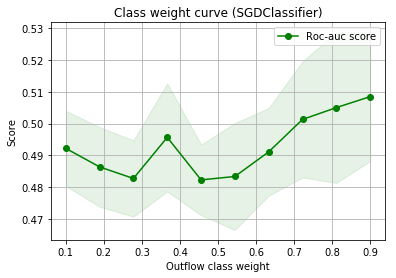

In [8]:
class_weights = np.linspace(.1, 0.9, 10)

plt.figure()
plt.title('Class weight curve (SGDClassifier)')
plt.xlabel('Outflow class weight')
plt.ylabel('Score')
plt.grid()
plt.fill_between(class_weights, scores_mean - scores_std, scores_mean + scores_std, alpha=0.1, color='g')
plt.plot(class_weights, scores_mean, 'o-', color='g', label='Roc-auc score')
_ = plt.legend(loc='best')

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [9]:
goups = df.groupby(by='target')
out_df = goups.get_group(1).fillna(0)
not_out_df = goups.get_group(-1).fillna(0)

In [10]:
scores_mean = []
scores_std = []

for size in np.linspace(.1, 1, 10):
    n_samples = int(not_out_df.shape[0] * size)
    train_df = pd.concat([out_df, not_out_df.sample(n_samples)])
    X = train_df.iloc[:, :-1].values
    y = train_df.target.values
    
    estimator = SGDClassifier(random_state=42)
    score = cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc')
    scores_mean.append(score.mean())
    scores_std.append(score.std())

In [11]:
scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)

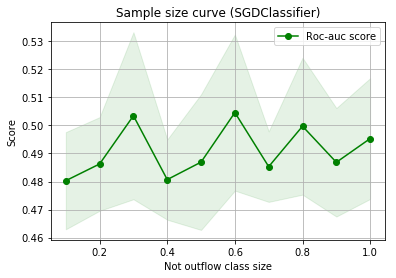

In [12]:
sanple_sizes = np.linspace(.1, 1, 10)

plt.figure()
plt.title('Sample size curve (SGDClassifier)')
plt.xlabel('Not outflow class size')
plt.ylabel('Score')
plt.grid()
plt.fill_between(sanple_sizes, scores_mean - scores_std, scores_mean + scores_std, alpha=0.1, color='g')
plt.plot(sanple_sizes, scores_mean, 'o-', color='g', label='Roc-auc score')
_ = plt.legend(loc='best')

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [13]:
numeric_cols = ['Var%d' % i for i in range(1, 191)]
cat_cols = [c for c in df.columns if c not in numeric_cols + ['target']]
empty_cols = [c for c in df.columns if df[c].dropna().shape[0] == 0]
numeric_cols = [c for c in numeric_cols if c not in empty_cols]

In [14]:
values = [pd.Series([0] * len(numeric_cols), index=numeric_cols), 
          df[numeric_cols].median(), 
          df[numeric_cols].mean(),
          df[numeric_cols].min(),
          df[numeric_cols].max()]

In [15]:
%%time
scores_mean = []
scores_std = []

y = df.target.values

for val in values:
    
    temp_df = df[numeric_cols]
    
    for c in temp_df.columns:
        temp_df[c].fillna(val[c], inplace=True)
        
    X = pd.concat([temp_df, df[cat_cols]], axis=1).values
    estimator = SGDClassifier(random_state=42, class_weight=class_weight)
    score = cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc')
    scores_mean.append(score.mean())
    scores_std.append(score.std())

Wall time: 49.6 s


In [16]:
grouped = df[numeric_cols].groupby(df['target'])
values = [(grouped.get_group(-1).median(), grouped.get_group(1).median()),
         (grouped.get_group(-1).mean(), grouped.get_group(1).mean()),
         (grouped.get_group(-1).min(), grouped.get_group(1).min()),
         (grouped.get_group(-1).max(), grouped.get_group(1).max())]

In [17]:
grouped = df.groupby(by = 'target')

for val in values:
    
    churn_df = grouped.get_group(1)
    no_churn_df = grouped.get_group(-1)
    
    for c in numeric_cols:
        no_churn_df[c].fillna(val[0][c], inplace=True)
        churn_df[c].fillna(val[1][c], inplace=True)
    
    temp_df = pd.concat([churn_df, no_churn_df])[numeric_cols + cat_cols + ['target']]
    
    X = temp_df.iloc[:, :-1].values
    y = temp_df.target.values
    estimator = SGDClassifier(random_state=42, class_weight=class_weight)
    score = cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc')
    scores_mean.append(score.mean())
    scores_std.append(score.std())

In [18]:
scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)

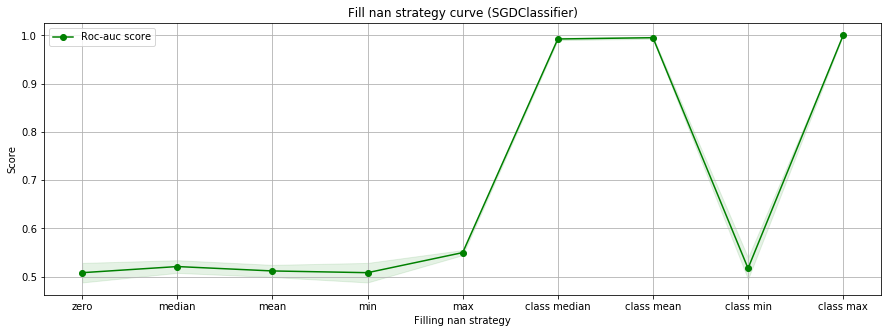

In [19]:
labels = ['zero', 'median', 'mean', 'min', 'max', 'class median', 'class mean', 'class min', 'class max']
temp = np.linspace(1, 9, 9)

plt.figure(figsize=(15, 5))
plt.title('Fill nan strategy curve (SGDClassifier)')
plt.xlabel('Filling nan strategy')
plt.ylabel('Score')
plt.grid()
plt.fill_between(temp, scores_mean - scores_std, scores_mean + scores_std, alpha=0.1, color='g')
plt.plot(temp, scores_mean, 'o-', color='g', label='Roc-auc score')
plt.legend(loc='best')
_ = plt.xticks(temp, labels, rotation='horizontal')

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [20]:
raw_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_data.train'))
labels = pd.read_csv(os.path.join(PATH_TO_DATA, 'orange_small_churn_labels.train'), header=None)
labels.columns = ['lbl']

In [21]:
%%time
grouped = raw_df.iloc[:, -40:].groupby(labels.lbl)
outflow = grouped.get_group(1)
not_outflow = grouped.get_group(-1)

replace_dict = {}

for c in outflow.columns:
    unique_outflow = outflow[c].dropna().unique()
    unique_not_outflow = not_outflow[c].dropna().unique()
    
    intersect = np.intersect1d(unique_outflow, unique_not_outflow)
    to_replase = [v for v in unique_not_outflow if v not in intersect]
    cat = c + '_not_outflow'
    
    temp_dict = {v: cat for v in to_replase}
    replace_dict[c] = temp_dict

Wall time: 2.56 s


In [22]:
dummies_raw_df = pd.get_dummies(raw_df.replace(replace_dict), columns=raw_df.columns[-40:])

In [23]:
scores = pd.Series()

In [24]:
%%time
X = dummies_raw_df.fillna(0).values
y = labels.lbl.values

estimator = SGDClassifier(random_state=42)
score = cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc')
print(score)
scores['ohe'] = score.mean()

[ 0.49311321  0.48182026  0.47156373  0.46479792  0.51032783]
Wall time: 17min 22s


In [25]:
label_raw_df = raw_df

for c in label_raw_df.columns[-40:]:
    label_raw_df[c] = label_raw_df[c].astype('category').cat.codes

label_raw_df.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,0,3696,0,-1,-1,14,0,29,-1,-1
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,4,347,0,-1,0,22,2,2,1,-1
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,6,2498,0,-1,-1,7,3,25,1,-1
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,4,2602,0,-1,-1,22,2,8,-1,-1
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,4,1375,0,-1,-1,12,2,8,-1,-1


In [26]:
%%time
X = label_raw_df.fillna(0).values
y = labels.lbl.values

estimator = SGDClassifier(random_state=42)
score = cross_val_score(estimator=estimator, cv=skf, X=X, y=y, scoring='roc_auc')
print(score)
scores['le'] = score.mean()

[ 0.49610525  0.48167273  0.47356079  0.46909027  0.50976011]
Wall time: 1.88 s


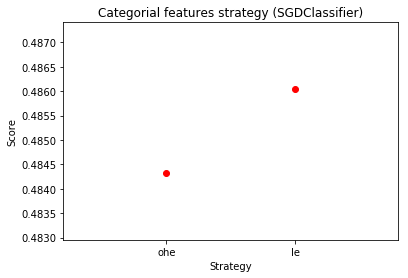

In [27]:
plt.title('Categorial features strategy (SGDClassifier)')
plt.xlabel('Strategy')
plt.ylabel('Score')
plt.plot([1, 2], scores.values, 'ro')
plt.margins(0.8)
_ = plt.xticks([1, 2], scores.index, rotation='horizontal')

Ну что тут можно сказать, качество в обоих случаях одинаково ужасное.......

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [28]:
scores = pd.Series()

X = df.iloc[:, :-1].fillna(0).values
y = df.target.values

for penalty in ['l1', 'l2']:
    lsvc = LinearSVC(penalty=penalty, dual=False).fit(X, y)
    model = SelectFromModel(lsvc, prefit=True)
    X_new = model.transform(X)
    
    estimator = SGDClassifier(random_state=42)
    score = cross_val_score(estimator=estimator, cv=skf, X=X_new, y=y, scoring='roc_auc')
    scores[penalty] = score.mean()

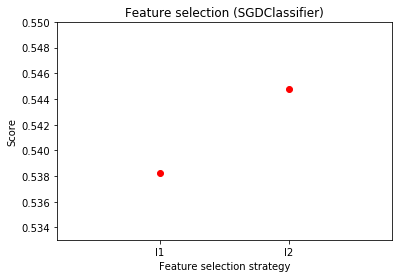

In [29]:
plt.title('Feature selection (SGDClassifier)')
plt.xlabel('Feature selection strategy')
plt.ylabel('Score')
plt.plot([1, 2], scores.values, 'ro')
plt.margins(0.8)
_ = plt.xticks([1, 2], scores.index, rotation='horizontal')

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [30]:
pipe = Pipeline([("classifier", SGDClassifier())])

param_grid = [
    {
    "classifier__alpha": [0.0001, 0.01, 0.1, 1],
    "classifier__loss": [ "hinge", "log"]
    }
]

grid = GridSearchCV(pipe, cv=skf, n_jobs=-1, param_grid=param_grid, scoring='roc_auc')
grid.fit(X, y)

print(grid.best_score_)
print(grid.best_params_)

0.505697440746
{'classifier__alpha': 0.0001, 'classifier__loss': 'hinge'}


In [31]:
grid.grid_scores_

[mean: 0.50570, std: 0.02175, params: {'classifier__alpha': 0.0001, 'classifier__loss': 'hinge'},
 mean: 0.49870, std: 0.01514, params: {'classifier__alpha': 0.0001, 'classifier__loss': 'log'},
 mean: 0.49633, std: 0.01614, params: {'classifier__alpha': 0.01, 'classifier__loss': 'hinge'},
 mean: 0.48507, std: 0.00950, params: {'classifier__alpha': 0.01, 'classifier__loss': 'log'},
 mean: 0.48167, std: 0.01177, params: {'classifier__alpha': 0.1, 'classifier__loss': 'hinge'},
 mean: 0.49229, std: 0.01451, params: {'classifier__alpha': 0.1, 'classifier__loss': 'log'},
 mean: 0.48977, std: 0.01895, params: {'classifier__alpha': 1, 'classifier__loss': 'hinge'},
 mean: 0.48821, std: 0.01607, params: {'classifier__alpha': 1, 'classifier__loss': 'log'}]

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [32]:
estimator = SGDClassifier(random_state=42).fit(X, y)
pd.Series(abs(estimator.coef_[0]), index=df.columns[:-1]).sort_values(ascending=False)

Var131                        4.072416e+06
Var180                        1.621823e+06
Var154                        1.153768e+06
Var94                         5.969971e+05
Var133                        5.611598e+05
Var139                        5.234451e+05
Var108                        5.033701e+05
Var125                        4.498155e+05
Var5                          4.062003e+05
Var33                         4.001362e+05
Var76                         3.970452e+05
Var162                        3.623727e+05
Var53                         3.609891e+05
Var51                         3.249786e+05
Var149                        2.911722e+05
Var136                        2.729239e+05
Var13                         2.688618e+05
Var124                        2.630859e+05
Var59                         2.355668e+05
Var177                        2.285041e+05
Var182                        1.939642e+05
Var69                         1.839667e+05
Var153                        1.816477e+05
Var140     

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [33]:
estimator = SGDClassifier(random_state=42).fit(X, y)

In [34]:
proba = estimator.predict(X)
idxs = [idx for idx, v in enumerate(proba) if v != y[idx]]
err_df = df.iloc[idxs]

In [35]:
print(err_df.target.value_counts())
print(df.target.value_counts())

 1    2902
-1     548
Name: target, dtype: int64
-1    37024
 1     2976
Name: target, dtype: int64


Здесь вынужден признать что пока не особо представляю на что надо смотреть.

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [37]:
class_weight = {1:0.9, -1:0.1}

values_to_fill = df[numeric_cols].max()

train_df = df[numeric_cols]
    
for c in train_df.columns:
    train_df[c].fillna(values_to_fill[c], inplace=True)

train_df = pd.concat([train_df, df[cat_cols + ['target']]], axis=1)
    
goups = train_df.groupby(by='target')
out_df = goups.get_group(1).fillna(0)
not_out_df = goups.get_group(-1).fillna(0)

n_samples = int(not_out_df.shape[0] * 0.6)
train_df = pd.concat([out_df, not_out_df.sample(n_samples)])
X = train_df.iloc[:, :-1].values
y = train_df.target.values

In [38]:
lsvc = LinearSVC(penalty='l1', dual=False).fit(X, y)
model = SelectFromModel(lsvc, prefit=True)
X_new = model.transform(X)

estimator = SGDClassifier(alpha=0.0001, random_state=42)
cross_val_score(estimator=estimator, cv=skf, X=X_new, y=y, scoring='roc_auc')

array([ 0.65885028,  0.653101  ,  0.64064443,  0.65394871,  0.68446948])

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

Для улучшении модели можно:
 * Рассмотреть другие стратегии заполнения пустых значений.
 * Рассмотреть новые стратегии отбора признаков, например на основе кореляции с целевой переменной
 * И конечно же посмотреть в сторону новых моделей таких как LogisticRegression например.